# Connect to Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
!ls '/content/gdrive/My Drive/Machine_Deep Learning/Concrete Strength Analyst'

Concrete_Data.csv


# **Import Library**

In [70]:
%matplotlib inline

!pip install pyforest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pyforest import *

import warnings
warnings.filterwarnings('ignore')

In [72]:
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.utils import resample
from scipy import stats
from scipy.stats import zscore
from numpy import asarray

# Load Dataset from UCI


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Machine_Deep Learning/Concrete Strength Analyst/Concrete_Data.csv')

In [11]:
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

In [15]:
df = df.rename(columns={"Cement (component 1)(kg in a m^3 mixture)":"cement",
                        "Blast Furnace Slag (component 2)(kg in a m^3 mixture)":"slag",
                        "Fly Ash (component 3)(kg in a m^3 mixture)":"ash",
                        "Water  (component 4)(kg in a m^3 mixture)":"water",
                        "Superplasticizer (component 5)(kg in a m^3 mixture)":"superplastic",
                        "Coarse Aggregate  (component 6)(kg in a m^3 mixture)":"coarseagg",
                        "Fine Aggregate (component 7)(kg in a m^3 mixture)":"fineagg",
                        "Age (day)":"age",
                        "Concrete compressive strength(MPa, megapascals) ":"strength"})

In [47]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [18]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


# Exploratory Data Analysis

<IPython.core.display.Javascript object>

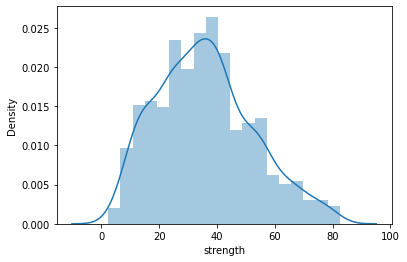

In [19]:
sns.distplot(df['strength'])

Distribution looks normal, no need to make any change here.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<function matplotlib.pyplot.show>

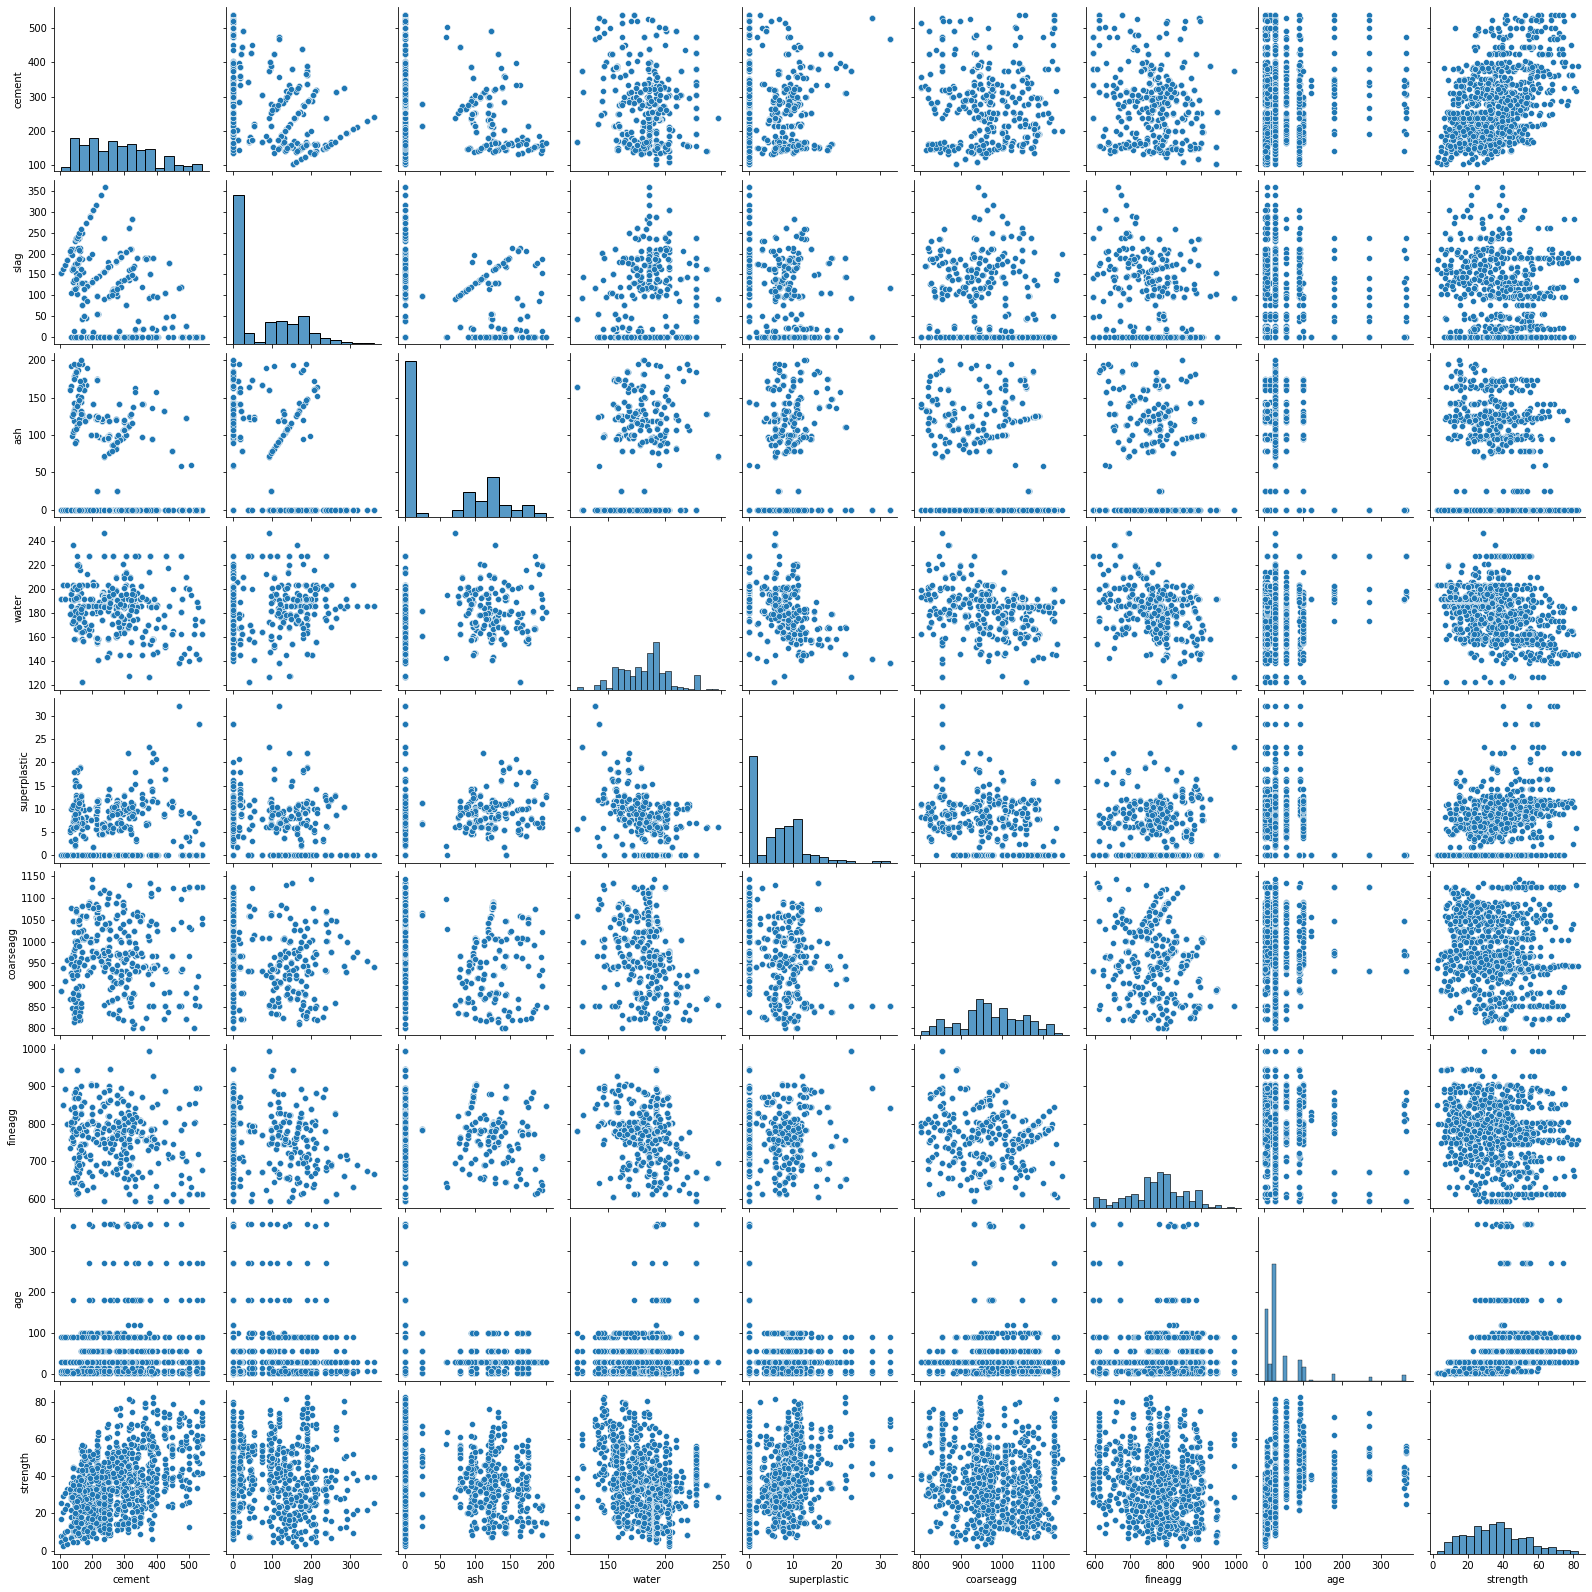

In [20]:
sns.pairplot(df)
plt.show

## Correlation

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

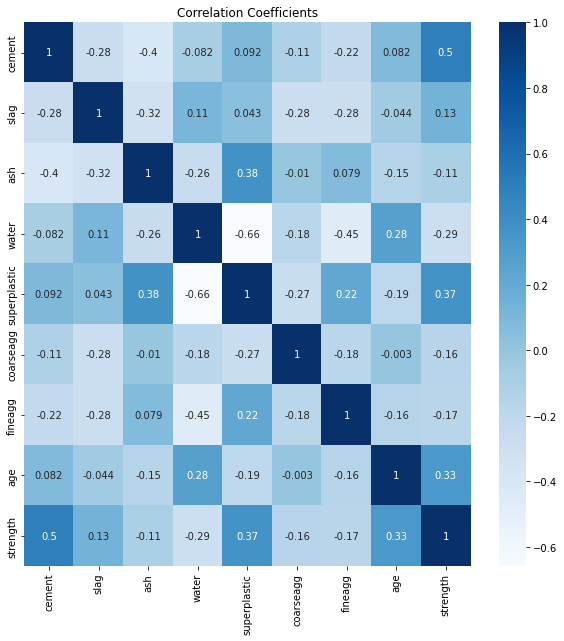

In [26]:
corr = df.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, cmap = 'Blues', annot = True)
plt.title('Correlation Coefficients')
plt.show()

As we can see, the highest positive correlation is between Strength and Cement
Follows with superplastic and age.

We can sort the correlation to make it easier for us to see

In [27]:
corr_sorted = corr.unstack().sort_values(kind='quicksort', ascending=False)

In [38]:
print(corr_sorted[corr_sorted!=1].head(10))
print("")
print(corr_sorted[corr_sorted!=1].tail(10))

cement        strength        0.497832
strength      cement          0.497832
ash           superplastic    0.377503
superplastic  ash             0.377503
              strength        0.366079
strength      superplastic    0.366079
age           strength        0.328873
strength      age             0.328873
water         age             0.277618
age           water           0.277618
dtype: float64

strength      water          -0.289633
water         strength       -0.289633
slag          ash            -0.323580
ash           slag           -0.323580
              cement         -0.397467
cement        ash            -0.397467
fineagg       water          -0.450661
water         fineagg        -0.450661
superplastic  water          -0.657533
water         superplastic   -0.657533
dtype: float64


# Feature Engineering & Model Building

## Data Preparation

Split the feature and target variable

In [40]:
X = df.drop('strength',axis=1)
y = df['strength']

Normalized using Z Score

In [41]:
Xscaled = X.apply(zscore)
Xscaled_df = pd.DataFrame(Xscaled, columns = df.columns)

<IPython.core.display.Javascript object>

Split train and test dataset

In [42]:
X_train,X_test,y_train,y_test = train_test_split(Xscaled,y, test_size=0.3,random_state=1)

## Applying Model

### 1. Random Forest Regressor

In [43]:
randomFR = RandomForestRegressor()
randomFR.fit(X_train, y_train)

RandomForestRegressor()

In [68]:
yPred = randomFR.predict(X_test)
print(yPred)

[22.9957     13.5961     23.5409     12.5454     31.3659     62.6964
 21.1952     49.0869     39.8659     19.2049     37.5608     14.0742
 39.6893     30.5343     11.8012     27.772      37.274      54.5597
 59.178      30.1889     24.3188     51.5895     16.331      58.49685
 63.898725   42.7984     33.1832     32.3592     34.905      13.3173
 41.9193     51.621525   26.1147     19.8415     36.123      37.2897
 15.6596     28.2635     23.7803     11.2722     32.8618     15.3829
 47.1085     37.4189     31.3917     27.6459     32.5332     24.4552
 33.39725    50.6457     26.4758     36.8744     58.9228     55.0729
 59.20288333  9.3191     30.9563     23.371      33.3048     44.2074
 49.9882     42.6384     52.0633     48.8229     26.8747     33.9626
 50.5176     35.1863     45.06       26.7414     36.021525   26.0156
 37.2229     11.5775     70.0483     59.30419667 49.4486     13.9239
 59.927525   48.8502     35.4669     46.6349     51.5323     38.1167
 34.7237     46.6376     30.7449 

In [45]:
randomFR.score(X_test,y_test)

0.8836805316661354

In [81]:
data = [173.5,50.1,173.5,164.8,6.5,1006.2,793.5,28]
new_data = asarray([data])
predict = randomFR.predict(new_data)
print(predict)

[59.3313]


2. XGBoost Regressor

In [62]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [63]:
xgr = XGBRegressor()

xgr.fit(X_train,y_train);

[05:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [76]:
xy_pred = xgr.predict(X_test)

In [77]:
xgr.score(X_train,y_train)

0.9484692321666962

ValueError: ignored